<a href="https://colab.research.google.com/github/skpatel0813/keyword-KeyPhraseExtraction/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TF-IDF

In [65]:
# --- PART 1: Setup and Load Data ---
from pathlib import Path
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set base directory
DATA_DIR = Path('/content/drive/MyDrive/cs7267-sp25/cs7267-sp25')

# Define train/test chapter IDs
train_chapters = [1, 2, 3, 4, 5, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19]
test_chapters = [6, 10, 11, 12]

def load_chapters(chapter_nums):
    texts = []
    for ch in chapter_nums:
        ch_path = DATA_DIR / f'ch{ch}.txt'
        if ch_path.exists():
            with open(ch_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
        else:
            print(f"[!] Chapter file not found: {ch_path}")
    return texts

# Load chapter texts
train_texts = load_chapters(train_chapters)
test_texts = load_chapters(test_chapters)

# ✅ Load index terms ONLY from training chapters using index_by_chapter.txt
index_by_chapter_path = DATA_DIR / 'index_by_chapter.txt'
train_chapter_ids = {f'ch{ch}' for ch in train_chapters}

training_index_terms = set()
current_chapter = None

with open(index_by_chapter_path, 'r', encoding='utf-8') as f:
    for line in f:
        stripped = line.strip()
        if stripped.lower().startswith("chapter"):
            current_chapter = 'ch' + stripped.split(" ")[1]
        elif stripped and current_chapter in train_chapter_ids:
            training_index_terms.add(stripped.lower())

print(f"Loaded {len(training_index_terms)} training index terms.")
print("Sample terms:", list(training_index_terms)[:10])

# (Optional) Load full index from index.txt if needed for final test evaluation
with open(DATA_DIR / 'index.txt', 'r', encoding='utf-8') as f:
    index_terms = [line.strip().lower() for line in f if line.strip()]
print(f"Loaded {len(index_terms)} total index terms from index.txt.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1047 training index terms.
Sample terms: ['dqn agents', 'svm regression', 'non-max suppression', 'tfds', 'constrained optimization', 'voice recognition', 'k-means', 'encoders', 'explainability and', 'visible units']
Loaded 1463 total index terms from index.txt.


In [66]:
# PART 2: Preprocessing and Phrase Extraction

# Install spaCy and download English model
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [67]:
import spacy
from spacy.matcher import Matcher
from collections import Counter
import re

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Define noun phrase pattern (adj? noun+)
matcher = Matcher(nlp.vocab)
pattern = [{'POS': 'ADJ', 'OP': '?'}, {'POS': 'NOUN'}, {'POS': 'NOUN', 'OP': '?'}]
matcher.add("NOUN_PHRASE", [pattern])

# Manual stopwords to filter generic/irrelevant noun phrases
manual_stopwords = {
    'time', 'value', 'example', 'figure', 'number', 'code', 'set', 'chapter',
    'step', 'output', 'input', 'state', 'instance', 'class'
}

# Helper: CamelCase splitter
def split_camel_case(phrase):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

# Main function to extract and clean phrases from a single text
def extract_candidate_phrases(text):
    doc = nlp(text)
    matches = matcher(doc)
    phrases = set()
    for match_id, start, end in matches:
        span = doc[start:end]
        phrase = span.text.strip()
        phrase = split_camel_case(phrase)
        phrase = phrase.lower()
        phrase = re.sub(r'[^a-zA-Z0-9\s\-]', '', phrase).strip()

        if (phrase
            and 1 <= len(phrase.split()) <= 5
            and phrase not in nlp.Defaults.stop_words
            and phrase not in manual_stopwords):
            phrases.add(phrase)
    return list(phrases)

# Apply to all training texts
train_candidates = []
for text in train_texts:
    train_candidates.extend(extract_candidate_phrases(text))

# Count top frequent phrases
top_phrases = Counter(train_candidates).most_common(30)

# Output top phrases
print(" Top cleaned candidate keyphrases:")
for phrase, count in top_phrases:
    print(f" - {phrase} ({count})")


✅ Top cleaned candidate keyphrases:
 - fact (15)
 - case (15)
 - features (15)
 - function (15)
 - feature (15)
 - data (15)
 - dataset (15)
 - tion (15)
 - model (15)
 - method (15)
 - performance (15)
 - approach (15)
 - size (15)
 - exercises (15)
 - learning (15)
 - way (15)
 - result (15)
 - ing (15)
 - idea (15)
 - values (15)
 - instances (15)
 - training (15)
 - cases (14)
 - hyperparameter (14)
 - task (14)
 - rest (14)
 - error (14)
 - words (14)
 - parameters (14)
 - image (14)


In [68]:
# --- STEP 1: Label candidate phrases using training_index_terms ---
from collections import Counter
import numpy as np

# Ensure train_candidates is already extracted
phrase_counts = Counter(train_candidates)
phrases = list(phrase_counts.keys())  # Unique phrases

# Label each phrase: 1 = concept (in training index), 0 = not concept
labels = [1 if p.lower().strip() in training_index_terms else 0 for p in phrases]
y = np.array(labels)

print(f"✅ Labeled {sum(y)} positive keyphrases out of {len(y)} total candidates.")


✅ Labeled 412 positive keyphrases out of 12009 total candidates.


In [69]:
# --- STEP 2: Feature Extraction ---
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Define handcrafted features
def phrase_features(phrase):
    words = phrase.split()
    tf = phrase_counts[phrase]
    length = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    starts_with_verb = int(nlp(words[0])[0].pos_ == 'VERB') if words else 0
    return [tf, length, avg_word_len, starts_with_verb]

# --- TF-IDF Features ---
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=1,         # Use 1 to avoid dropping rare phrases (change to 2+ for noise filtering)
    max_df=0.85
)
X_tfidf = vectorizer.fit_transform(phrases)

# --- Handcrafted Features ---
X_handcrafted = np.array([phrase_features(p) for p in phrases])

# --- Combine TF-IDF + handcrafted ---
X = hstack([X_tfidf, X_handcrafted])

# --- Sanity Check ---
assert X.shape[0] == len(y), "[!] Feature rows and label count must match!"
print("Feature matrix shape:", X.shape)
print("Label vector shape:  ", y.shape)


✅ Feature matrix shape: (12009, 11985)
✅ Label vector shape:   (12009,)


In [70]:
# --- STEP 3: Train and Evaluate Logistic Regression ---
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Sanity check
assert X.shape[0] == len(y), "[!] Feature and label size mismatch!"

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train classifier with class balancing
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_val)

print("\nClassification Report (Validation Set):\n")
print(classification_report(y_val, y_pred, target_names=["Not Concept", "Concept"]))



✅ Classification Report (Validation Set):

              precision    recall  f1-score   support

 Not Concept       0.97      0.96      0.96      2320
     Concept       0.13      0.17      0.15        82

    accuracy                           0.93      2402
   macro avg       0.55      0.56      0.56      2402
weighted avg       0.94      0.93      0.94      2402



In [71]:
# --- STEP 4: Apply Trained Model to Test Chapters ---

# Extract candidate phrases from test chapters
test_candidates = []
for text in test_texts:
    test_candidates.extend(extract_candidate_phrases(text))

# Deduplicate and clean
test_candidates = list(set(test_candidates))
print(f"Extracted {len(test_candidates)} unique candidate phrases from test chapters.")

# TF-IDF features for test phrases (reuse trained vectorizer)
X_test_tfidf = vectorizer.transform(test_candidates)

# Handcrafted features for test phrases
X_test_handcrafted = np.array([phrase_features(p) for p in test_candidates])

# Combine features
from scipy.sparse import hstack
X_test = hstack([X_test_tfidf, X_test_handcrafted])

# Sanity check
assert X_test.shape[0] == len(test_candidates), "Mismatch between features and phrases"

# Predict using trained model
test_preds = clf.predict(X_test)

# Collect only predicted keyphrases
predicted_concepts = [p for p, pred in zip(test_candidates, test_preds) if pred == 1]
print(f"Predicted {len(predicted_concepts)} key concepts from test chapters.")

# Show a few results
print("\nSample predicted concepts:")
print(predicted_concepts[:15])


✅ Extracted 4236 unique candidate phrases from test chapters.
✅ Predicted 318 key concepts from test chapters.

🔍 Sample predicted concepts:
['convergence theorem', 'library', 'loss instance', 'loss function', 'initial learning', 'adaptive learning', 'new parameter vectors', 'learning rate', 'generalization error', 'bias terms', 'cells', 'bayesian inference', 'learning curves', 'rnns', 'look']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Final edge count: 2196 (co-occurrence ≥ 2)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


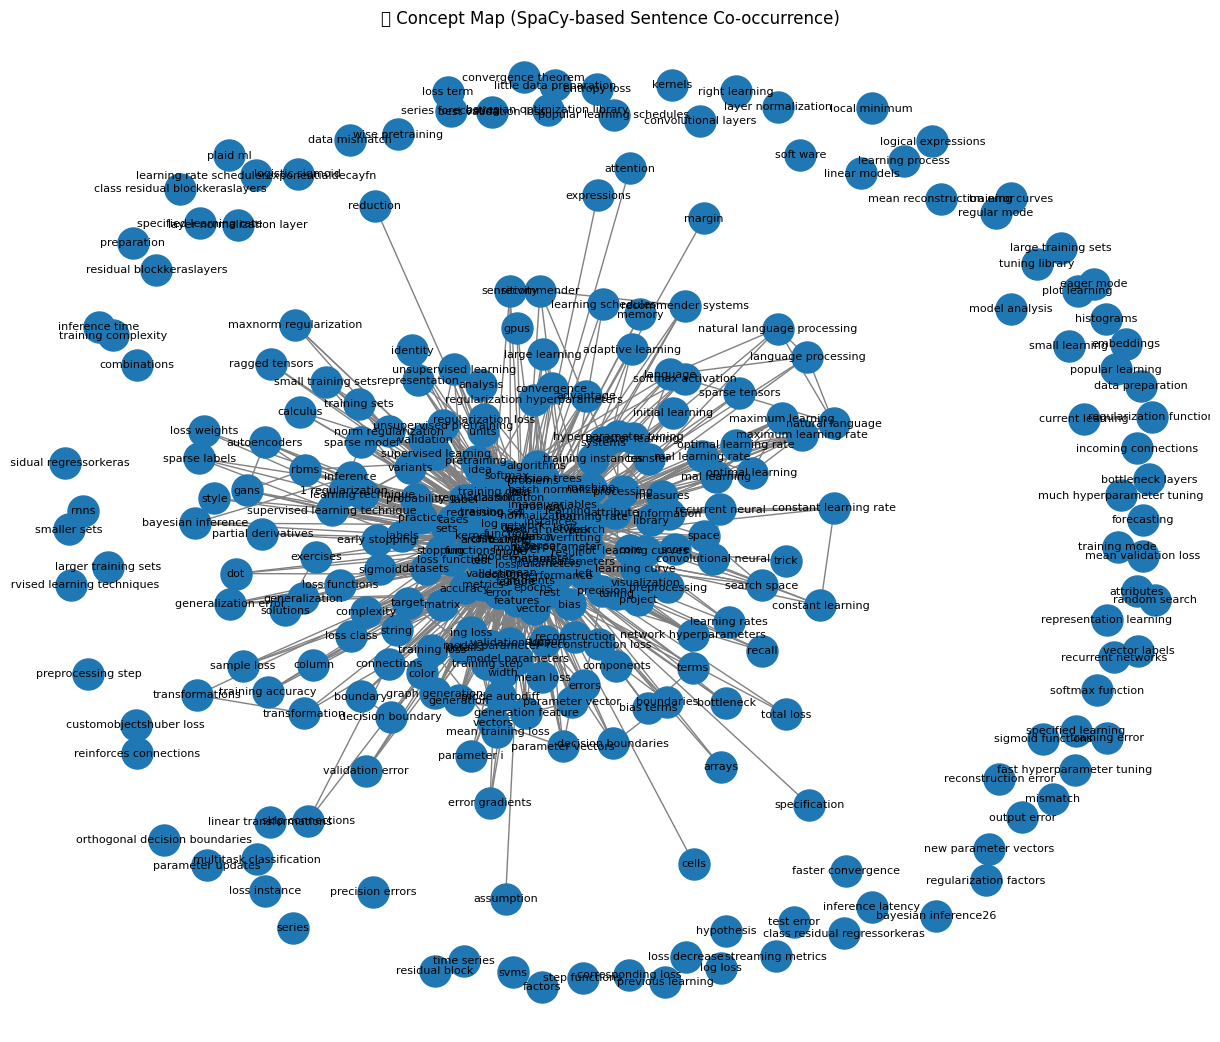

In [72]:
# --- STEP 5: Build Co-occurrence Graph from Predicted Concepts ---
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import nltk
nltk.download('punkt_tab')
from nltk import sent_tokenize

# Extract co-occurrence edges based on sentence-level matching
co_occurrence_edges = defaultdict(int)

# Search co-occurrence within each sentence of test text
for text in test_texts:
    sentences = sent_tokenize(text)
    for sent in sentences:
        sent = sent.lower()
        present = [c for c in predicted_concepts if c in sent]
        for c1, c2 in combinations(set(present), 2):
            pair = tuple(sorted([c1, c2]))
            co_occurrence_edges[pair] += 1

# Filter edges with minimum threshold
min_threshold = 2
final_edges = {pair: count for pair, count in co_occurrence_edges.items() if count >= min_threshold}

print(f" Final edge count: {len(final_edges)} (co-occurrence ≥ {min_threshold})")

# --- Build and visualize the graph ---
G = nx.Graph()

# Add nodes (concepts)
G.add_nodes_from(predicted_concepts)

# Add edges (with weights)
for (c1, c2), weight in final_edges.items():
    G.add_edge(c1, c2, weight=weight)

# Draw graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray')
plt.title("🧠 Concept Map (SpaCy-based Sentence Co-occurrence)")
plt.show()


RAKE

In [73]:
# --- Load training-only index terms ---
train_chapter_ids = {'Chapter 1', 'Chapter 2', 'Chapter 3', 'Chapter 4', 'Chapter 5',
                     'Chapter 7', 'Chapter 8', 'Chapter 9',
                     'Chapter 13', 'Chapter 14', 'Chapter 15', 'Chapter 16', 'Chapter 17', 'Chapter 18', 'Chapter 19'}

training_index_terms = set()
with open("/content/drive/MyDrive/cs7267-sp25/cs7267-sp25/index_by_chapter.txt", 'r', encoding='utf-8') as f:
    current_chapter = None
    for line in f:
        line = line.strip()
        if line.startswith("Chapter"):
            current_chapter = line
        elif line and current_chapter in train_chapter_ids:
            training_index_terms.add(line.lower().strip())

print(f"✅ Loaded {len(training_index_terms)} training index terms.")
print("🔍 Sample:", list(training_index_terms)[:10])


✅ Loaded 1047 training index terms.
🔍 Sample: ['dqn agents', 'svm regression', 'non-max suppression', 'tfds', 'constrained optimization', 'voice recognition', 'k-means', 'encoders', 'explainability and', 'visible units']


In [74]:
!pip install -q rake-nltk

from rake_nltk import Rake
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re

nltk.download('stopwords')

rake = Rake(
    stopwords=stopwords.words('english'),
    min_length=2,
    max_length=4
)

full_train_text = " ".join(train_texts)

rake.extract_keywords_from_text(full_train_text)
rake_results = rake.get_ranked_phrases_with_scores()

min_score_threshold = 3.0
filtered_phrases = [
    phrase.lower().strip()
    for score, phrase in rake_results
    if score >= min_score_threshold
    and phrase.strip()
    and not re.search(r'\d', phrase)
    and len(phrase.split()) <= 4
]

stop_set = set(stopwords.words('english'))
filtered_phrases = [
    phrase for phrase in filtered_phrases
    if any(word not in stop_set for word in phrase.split())
]

TOP_N = 300
rake_phrases = list(dict.fromkeys(filtered_phrases))[:TOP_N]

print(f"RAKE Extracted {len(rake_phrases)} phrases:")
print(rake_phrases[:10])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


RAKE Extracted 300 phrases:
['fan temp perf pwr', 'shuai li et al', 'samy bengio et al', 'rico sennrich et al', 'peter norvig et al', 'malvina nissim et al', 'le et al .’', 'kyunghyun cho et al', 'césar laurent et al', 'christian szegedy et al']


In [75]:
def partial_match(pred, index_set):
    return any(pred in idx or idx in pred for idx in index_set)

TP = sum([1 for p in rake_phrases if partial_match(p, training_index_terms)])
FP = len(rake_phrases) - TP
FN = len(training_index_terms) - TP

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\n📊 RAKE Evaluation (Partial Matching):")
print(f"True Positives:   {TP}")
print(f"False Positives:  {FP}")
print(f"False Negatives:  {FN}")
print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")



📊 RAKE Evaluation (Partial Matching):
True Positives:   159
False Positives:  141
False Negatives:  888

Precision: 0.5300
Recall:    0.1519
F1-Score:  0.2361


In [76]:
test_text = " ".join(test_texts)
rake.extract_keywords_from_text(test_text)
test_results = rake.get_ranked_phrases_with_scores()

test_phrases = [
    phrase.lower().strip()
    for score, phrase in test_results
    if score >= min_score_threshold
    and phrase.strip()
    and not re.search(r'\d', phrase)
    and len(phrase.split()) <= 4
]
test_phrases = list(dict.fromkeys(test_phrases))[:300]
print(f"RAKE Test Phrases: {len(test_phrases)}")


RAKE Test Phrases: 300


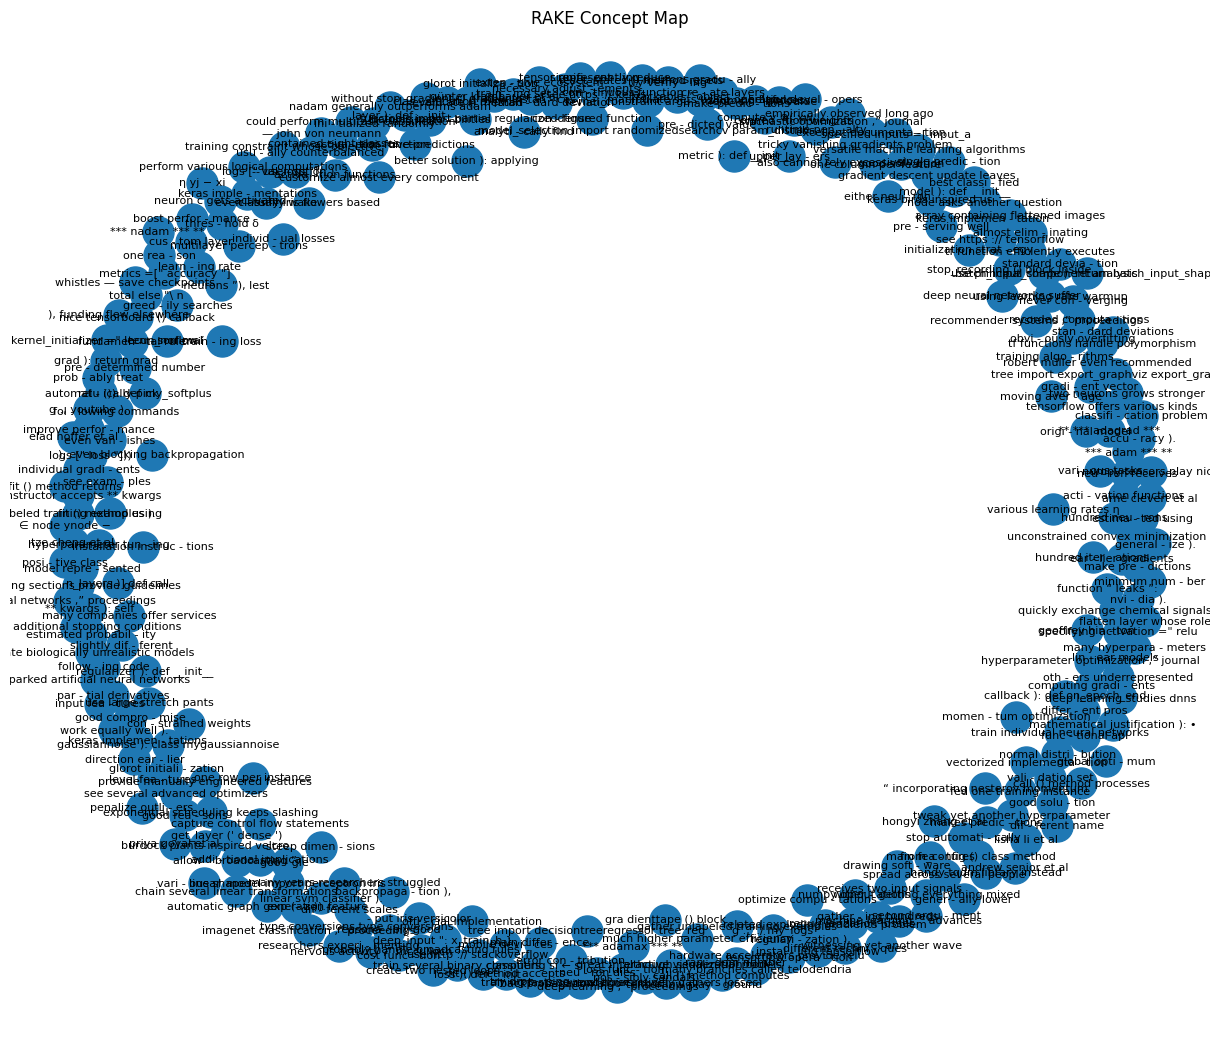

In [77]:
import networkx as nx
from nltk import sent_tokenize
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt

test_sentences = []
for text in test_texts:
    test_sentences.extend(sent_tokenize(text))

co_occurrence = defaultdict(int)
for sent in test_sentences:
    sent = sent.lower()
    present = [p for p in test_phrases if p in sent]
    for c1, c2 in combinations(set(present), 2):
        co_occurrence[tuple(sorted((c1, c2)))] += 1

G = nx.Graph()
for phrase in test_phrases:
    G.add_node(phrase)
for (c1, c2), w in co_occurrence.items():
    if w >= 2:
        G.add_edge(c1, c2, weight=w)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray')
plt.title("RAKE Concept Map")
plt.show()


In [78]:
!pip install -q transformers
from transformers import pipeline
from nltk import sent_tokenize
from tqdm import tqdm

ner = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True)

train_sentences = []
for text in train_texts:
    train_sentences.extend(sent_tokenize(text))

bert_phrases = set()
for sent in tqdm(train_sentences):
    try:
        entities = ner(sent)
        for ent in entities:
            phrase = ent['word'].lower().strip()
            if 1 <= len(phrase.split()) <= 5:
                bert_phrases.add(phrase)
    except:
        continue

bert_phrases = list(bert_phrases)
print(f"BERT-NER Extracted {len(bert_phrases)} phrases")
print(bert_phrases[:10])


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(
100%|██████████| 6982/6982 [01:19<00:00, 87.86it/s]

BERT-NER Extracted 1831 phrases
['g', 'data mining', 'at', '5', 'adaboostclass', '##lity', 'sid', '##ment learning', 'rico sennrich', 'convolutional neural networks']


In [79]:
# --- BERT-NER Partial Match Evaluation ---
def partial_match(pred, index_set):
    return any(pred in idx or idx in pred for idx in index_set)

bert_TP = sum([1 for p in bert_phrases if partial_match(p, training_index_terms)])
bert_FP = len(bert_phrases) - bert_TP
bert_FN = len(training_index_terms) - bert_TP

bert_precision = bert_TP / (bert_TP + bert_FP) if (bert_TP + bert_FP) > 0 else 0
bert_recall = bert_TP / (bert_TP + bert_FN) if (bert_TP + bert_FN) > 0 else 0
bert_f1 = 2 * bert_precision * bert_recall / (bert_precision + bert_recall) if (bert_precision + bert_recall) > 0 else 0

print("\n BERT-NER Evaluation (Partial Matching):")
print(f"True Positives:   {bert_TP}")
print(f"False Positives:  {bert_FP}")
print(f"False Negatives:  {bert_FN}")
print(f"\nPrecision: {bert_precision:.4f}")
print(f"Recall:    {bert_recall:.4f}")
print(f"F1-Score:  {bert_f1:.4f}")



📊 BERT-NER Evaluation (Partial Matching):
True Positives:   912
False Positives:  919
False Negatives:  135

Precision: 0.4981
Recall:    0.8711
F1-Score:  0.6338


In [80]:
test_sentences = []
for text in test_texts:
    test_sentences.extend(sent_tokenize(text))

test_bert_phrases = set()
for sent in tqdm(test_sentences):
    try:
        entities = ner(sent)
        for ent in entities:
            phrase = ent['word'].lower().strip()
            if 1 <= len(phrase.split()) <= 5:
                test_bert_phrases.add(phrase)
    except:
        continue

test_bert_phrases = list(test_bert_phrases)
print(f"BERT-NER Test Phrases: {len(test_bert_phrases)}")


100%|██████████| 1998/1998 [00:23<00:00, 84.83it/s]

BERT-NER Test Phrases: 549


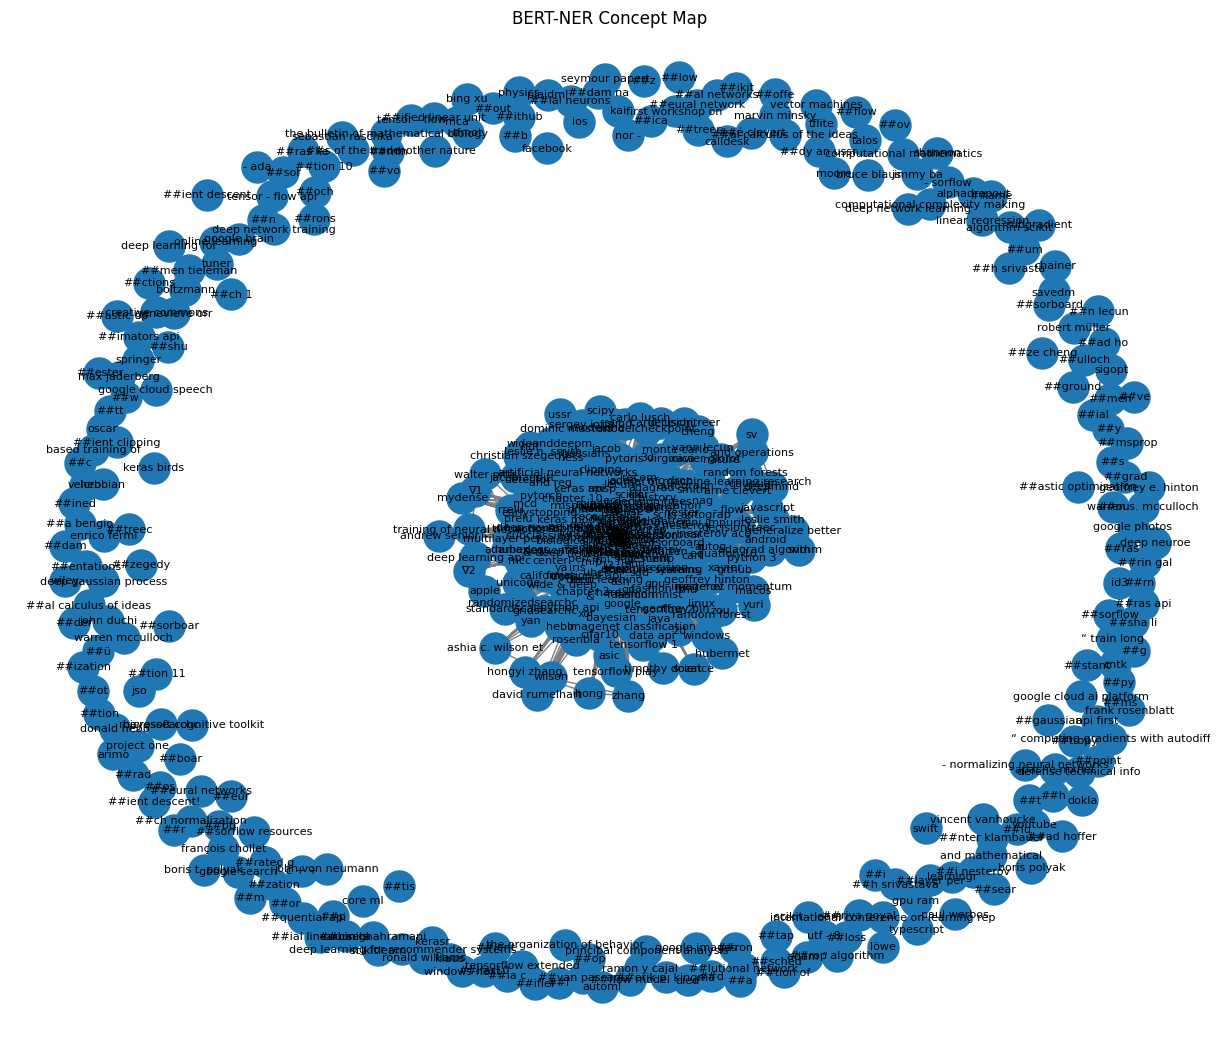

In [81]:
co_occurrence = defaultdict(int)

for sent in test_sentences:
    sent = sent.lower()
    present = [p for p in test_bert_phrases if p in sent]
    for c1, c2 in combinations(set(present), 2):
        co_occurrence[tuple(sorted((c1, c2)))] += 1

G = nx.Graph()
for phrase in test_bert_phrases:
    G.add_node(phrase)
for (c1, c2), w in co_occurrence.items():
    if w >= 2:
        G.add_edge(c1, c2, weight=w)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray')
plt.title("BERT-NER Concept Map")
plt.show()


SciBERT

In [82]:
import nltk

# Download the punkt tokenizer
nltk.download('punkt')

# Download other necessary resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
import nltk
from nltk.tokenize import sent_tokenize

# Clear NLTK data cache
nltk.data.clear_cache()

# Ensure the punkt tokenizer is downloaded
nltk.download('punkt')

# Set NLTK data path
nltk.data.path.append('/root/nltk_data')

# Test case to validate punkt tokenizer
test_text = "This is a test sentence. Here is another one."

try:
    # Tokenize the test text into sentences
    sentences = sent_tokenize(test_text)
    print("Tokenized sentences:", sentences)
except LookupError as e:
    print("LookupError:", e)

Tokenized sentences: ['This is a test sentence.', 'Here is another one.']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [84]:
# --- PART 1: Generate token-labeled NER dataset from index terms ---
import re
from pathlib import Path
from datasets import Dataset
from transformers import AutoTokenizer
import spacy
from collections import Counter

# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Paths
DATA_DIR = Path("/content/drive/MyDrive/cs7267-sp25/cs7267-sp25")

# Load and lemmatize index terms
with open(DATA_DIR / "index.txt", "r", encoding="utf-8") as f:
    index_terms = [line.strip() for line in f if line.strip()]

nlp = spacy.load("en_core_web_sm")

def lemmatize_phrase(phrase):
    doc = nlp(phrase)
    return " ".join([
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha
    ])

lemmatized_index_terms = list({lemmatize_phrase(term) for term in index_terms})
tokenized_index_phrases = [tokenizer.tokenize(term) for term in lemmatized_index_terms if term]

# Labeling function with bounds-safe matching
def tokenize_and_label(text, tokenized_index_phrases):
    sentences = re.split(r'[.!?]\s+', text)
    examples = []

    for sentence in sentences:
        tokens = tokenizer.tokenize(sentence)
        labels = ['O'] * len(tokens)

        for phrase_tokens in tokenized_index_phrases:
            match_len = len(phrase_tokens)
            for i in range(len(tokens) - match_len + 1):
                if (
                    match_len > 0 and
                    i + match_len <= len(tokens) and
                    tokens[i:i + match_len] == phrase_tokens
                ):
                    labels[i] = 'B-CONCEPT'
                    for j in range(1, match_len):
                        if i + j < len(labels):
                            labels[i + j] = 'I-CONCEPT'

        examples.append((tokens, labels))
    return examples

# Build token-label pairs from training chapters
all_train_text = " ".join(train_texts).lower()
labeled_examples = tokenize_and_label(all_train_text, tokenized_index_phrases)

# Debug: Print label distribution
flat_labels = [tag for _, tag_seq in labeled_examples for tag in tag_seq]
print("\n📊 Label Distribution:", Counter(flat_labels))

# Debug: Print sample token-label pair
print("\n🧪 Sample labeled sentence:")
sample_tokens, sample_labels = labeled_examples[0]
for tok, tag in zip(sample_tokens, sample_labels):
    print(f"{tok:20} -> {tag}")

# Convert to HuggingFace dataset
def to_hf_format(examples):
    token_list, label_list = zip(*examples)
    return Dataset.from_dict({'tokens': token_list, 'ner_tags': label_list})

train_dataset = to_hf_format(labeled_examples)



📊 Label Distribution: Counter({'O': 232875, 'B-CONCEPT': 11427, 'I-CONCEPT': 3979})

🧪 Sample labeled sentence:
chapter              -> O
1                    -> O
the                  -> O
machine              -> O
learning             -> O
landscape            -> O
when                 -> O
most                 -> O
people               -> O
hear                 -> O
“                    -> O
machine              -> O
learning             -> O
,                    -> O
”                    -> O
they                 -> O
picture              -> O
a                    -> O
robot                -> O
:                    -> O
a                    -> O
depend               -> O
##able               -> O
but                  -> O
‐                    -> O
ler                  -> O
or                   -> O
a                    -> O
dead                 -> O
##ly                 -> O
termin               -> O
##ator               -> O
,                    -> O
depending            -> O
on 

In [86]:
# --- PART 2: Fine-Tune and Evaluate SciBERT NER ---
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import ClassLabel
from sklearn.metrics import classification_report
import numpy as np
import os

# Define label set
label_list = ["O", "B-CONCEPT", "I-CONCEPT"]
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
class_encoder = ClassLabel(num_classes=len(label_list), names=label_list)

# Step 1: Safely encode labels (convert strings → int, skip -100s)
def encode_labels(example):
    return {
        "labels": [
            class_encoder.str2int(tag) if isinstance(tag, str) and tag in class_encoder.names else tag
            for tag in example["ner_tags"]
        ]
    }

train_dataset = train_dataset.map(encode_labels)

# Step 2: Split into train/val
split_dataset = train_dataset.train_test_split(test_size=0.2, seed=42)
train_data = split_dataset["train"]
eval_data = split_dataset["test"]

# Step 3: Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModelForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Step 4: Tokenization + label alignment
MAX_LENGTH = 512

def tokenize_batch(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"],
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )
    labels = []
    for i, label in enumerate(batch["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [label[word_id] if word_id is not None else -100 for word_id in word_ids]
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

train_data = train_data.map(tokenize_batch, batched=True)
eval_data = eval_data.map(tokenize_batch, batched=True)

train_data = train_data.filter(lambda x: len(x["input_ids"]) <= MAX_LENGTH)
eval_data = eval_data.filter(lambda x: len(x["input_ids"]) <= MAX_LENGTH)

# Step 5: Metrics for evaluation
def compute_metrics(pred):
    true_labels = np.array(pred.label_ids).flatten()
    pred_labels = np.argmax(pred.predictions, axis=2).flatten()

    # Filter out -100s
    mask = true_labels != -100
    y_true = true_labels[mask]
    y_pred = pred_labels[mask]

    # Report
    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2],
        target_names=label_list,
        digits=4
    )
    print("\n📊 Classification Report:\n", report)

    return {
        "precision": float(np.mean(y_pred == y_true)),
        "recall": float(np.mean(y_pred == y_true)),  # simplified
        "f1": float(np.mean(y_pred == y_true)),       # for logging
    }

# Step 6: Training setup
training_args = TrainingArguments(
    output_dir="./scibert_ner_model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=1,
    save_strategy="no",
    logging_steps=50,
    disable_tqdm=False,
    fp16=True
)

# Step 7: Trainer
data_collator = DataCollatorForTokenClassification(tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Step 8: Train and Evaluate
trainer.train()

# Step 9: Save model
trainer.save_model("./scibert_ner_model")
tokenizer.save_pretrained("./scibert_ner_model")
trainer.model.save_pretrained("./scibert_ner_model", safe_serialization=False)

print("\n Saved model files:", os.listdir("./scibert_ner_model"))
print(" Label mapping:", model.config.id2label)


Map:   0%|          | 0/7119 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5695 [00:00<?, ? examples/s]

Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5695 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1424 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-86-8637f4c91036>:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.040000,0.037696,0.988361,0.988361,0.988361



📊 Classification Report:
               precision    recall  f1-score   support

           O     0.9931    0.9954    0.9943     55088
   B-CONCEPT     0.9423    0.9161    0.9290      2299
   I-CONCEPT     0.8748    0.8373    0.8557      1469

    accuracy                         0.9884     58856
   macro avg     0.9367    0.9163    0.9263     58856
weighted avg     0.9882    0.9884    0.9883     58856


 Saved model files: ['config.json', 'checkpoint-298', 'special_tokens_map.json', 'tokenizer.json', 'vocab.txt', 'training_args.bin', 'tokenizer_config.json', 'model.safetensors', 'checkpoint-418', 'pytorch_model.bin', 'runs']
 Label mapping: {0: 'O', 1: 'B-CONCEPT', 2: 'I-CONCEPT'}


In [87]:
# --- PART 3: Inference from Fine-Tuned SciBERT with Debug ---
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from tqdm import tqdm
import re
import os

# Load model with SafeTensors support
model_dir = "./scibert_ner_model"
inference_model = AutoModelForTokenClassification.from_pretrained(model_dir, use_safetensors=True)
inference_tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Setup pipeline
ner_pipeline = pipeline(
    "ner",
    model=inference_model,
    tokenizer=inference_tokenizer,
    aggregation_strategy="simple"
)

# Sentence-split test chapters
test_sentences = []
for text in test_texts:
    test_sentences.extend(re.split(r'(?<=[.!?]) +', text.strip()))

# Extract concept phrases with debugging
extracted_test_phrases = set()
print_every = 100
for idx, sent in enumerate(tqdm(test_sentences)):
    try:
        entities = ner_pipeline(sent)
        if idx % print_every == 0 and entities:
            print(f"\nSentence: {sent}")
            print(f" Raw entities: {entities}")

        for ent in entities:
            if ent["entity_group"] == "CONCEPT":
                phrase = ent["word"].lower().strip()
                if 1 <= len(phrase.split()) <= 5:
                    extracted_test_phrases.add(phrase)
    except Exception:
        continue

extracted_test_phrases = list(extracted_test_phrases)
print(f"\n Total extracted concept phrases: {len(extracted_test_phrases)}")
print("Sample:", extracted_test_phrases[:10])


Device set to use cuda:0
  1%|          | 16/1330 [00:00<00:16, 77.51it/s]


Sentence: CHAPTER 6
Decision Trees
Like SVMs, Decision Trees are versatile Machine Learning algorithms that can per‐ form both classification and regression tasks, and even multioutput tasks.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.6858238), 'word': 'decision trees', 'start': 10, 'end': 24}, {'entity_group': 'CONCEPT', 'score': np.float32(0.591579), 'word': 'decision trees', 'start': 36, 'end': 50}, {'entity_group': 'CONCEPT', 'score': np.float32(0.9662022), 'word': 'classification', 'start': 117, 'end': 131}, {'entity_group': 'CONCEPT', 'score': np.float32(0.5989989), 'word': 'regression', 'start': 136, 'end': 146}]


  9%|▊         | 116/1330 [00:01<00:14, 85.82it/s]


Sentence: One way to limit this prob‐ lem is to use Principal Component Analysis (see Chapter 8), which often results in a better orientation of the training data.
Figure 6-7.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.6902523), 'word': 'component analysis', 'start': 52, 'end': 70}, {'entity_group': 'CONCEPT', 'score': np.float32(0.9992219), 'word': 'training', 'start': 139, 'end': 147}]


 16%|█▋        | 217/1330 [00:02<00:12, 86.75it/s]


Sentence: XOR classification problem and an MLP that solves it
The Multilayer Perceptron and Backpropagation
An MLP is composed of one (passthrough) input layer, one or more layers of TLUs, called hidden layers, and one final layer of TLUs called the output layer (see Figure 10-7).
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.6326173), 'word': 'classification', 'start': 4, 'end': 18}, {'entity_group': 'CONCEPT', 'score': np.float32(0.7640677), 'word': 'multilayer', 'start': 57, 'end': 67}, {'entity_group': 'CONCEPT', 'score': np.float32(0.83523303), 'word': '##ron', 'start': 75, 'end': 78}, {'entity_group': 'CONCEPT', 'score': np.float32(0.9592738), 'word': 'backpropagation', 'start': 83, 'end': 98}, {'entity_group': 'CONCEPT', 'score': np.float32(0.6162939), 'word': '##through', 'start': 130, 'end': 137}, {'entity_group': 'CONCEPT', 'score': np.float32(0.96066535), 'word': 'input layer', 'start': 139, 'end': 150}, {'entity_group': 'CONCEPT', 'score': np.float32(0

 24%|██▍       | 317/1330 [00:03<00:12, 83.17it/s]


Sentence: For simplic‐ ity, we’ll scale the pixel intensities down to the 0–1 range by dividing them by 255.0 (this also converts them to floats):
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0 y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0
With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.99611795), 'word': 'label', 'start': 318, 'end': 323}]


 31%|███       | 407/1330 [00:04<00:11, 77.43it/s]


Sentence: As soon as it is created, notice that we call it like a function, passing it the input.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.9919214), 'word': 'function', 'start': 56, 'end': 64}]


 38%|███▊      | 510/1330 [00:06<00:10, 79.36it/s]


Sentence: You can partially alleviate this problem by assisting the search process manually: first run a quick random search using wide ranges of hyperparameter values, then run another search using smaller ranges of values centered on the best ones found during the first run, and so on.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.75789213), 'word': 'hyperparameter', 'start': 136, 'end': 150}]


 46%|████▌     | 612/1330 [00:07<00:08, 88.69it/s]


Sentence: Training a deep DNN isn’t a walk in the park.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.9985702), 'word': 'training', 'start': 0, 'end': 8}]


 53%|█████▎    | 711/1330 [00:08<00:07, 81.11it/s]


Sentence: […] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 valida‐ tion error (and 4.8% test error), exceeding the accuracy of human raters.
Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described later in this chapter).
Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier).
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.94088775), 'word': 'ensemble', 'start': 13, 'end': 21}, {'entity_group': 'CONCEPT', 'score': np.float32(0.80844635), 'word': 'classification', 'start': 106, 'end': 120}, {'entity_group': 'CONCEPT', 'score': np.float32(0.674429), 'word': 'test', 'start': 171, 'end': 175}, {'entity_group': 'CONCEPT', 'score': np.float32(0.90803164), 'word': 'accu

 61%|██████    | 811/1330 [00:09<00:06, 82.11it/s]


Sentence: Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.75319535), 'word': 'boost', 'start': 19, 'end': 24}, {'entity_group': 'CONCEPT', 'score': np.float32(0.9525575), 'word': 'gradient descent', 'start': 78, 'end': 94}]


 84%|████████▍ | 1115/1330 [00:13<00:02, 83.26it/s]


Sentence: Plus, other parameters may also need to change over time (e.g., a momentum optimizer keeps track of past gradients).
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.90261173), 'word': 'momentum', 'start': 66, 'end': 74}]


 91%|█████████ | 1210/1330 [00:14<00:01, 75.38it/s]


Sentence: To create a layer with multiple outputs, the call() method should return the list of outputs, and compute_output_shape() should return the list of batch output shapes (one per output).
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.9990658), 'word': 'layer', 'start': 12, 'end': 17}]


 99%|█████████▊| 1312/1330 [00:15<00:00, 79.87it/s]


Sentence: This should feel familiar if you know TensorFlow 1, as graph mode was the default mode.
 Raw entities: [{'entity_group': 'CONCEPT', 'score': np.float32(0.99659973), 'word': 'tensor', 'start': 38, 'end': 44}]


100%|██████████| 1330/1330 [00:16<00:00, 82.27it/s]


 Total extracted concept phrases: 334
Sample: ['purity', 'constraint function', 'unsupervised pre', 'derivative', 'score', '##parameter optimization', 'estimator', 'epoch', 'component analysis', 'generalization gap']


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


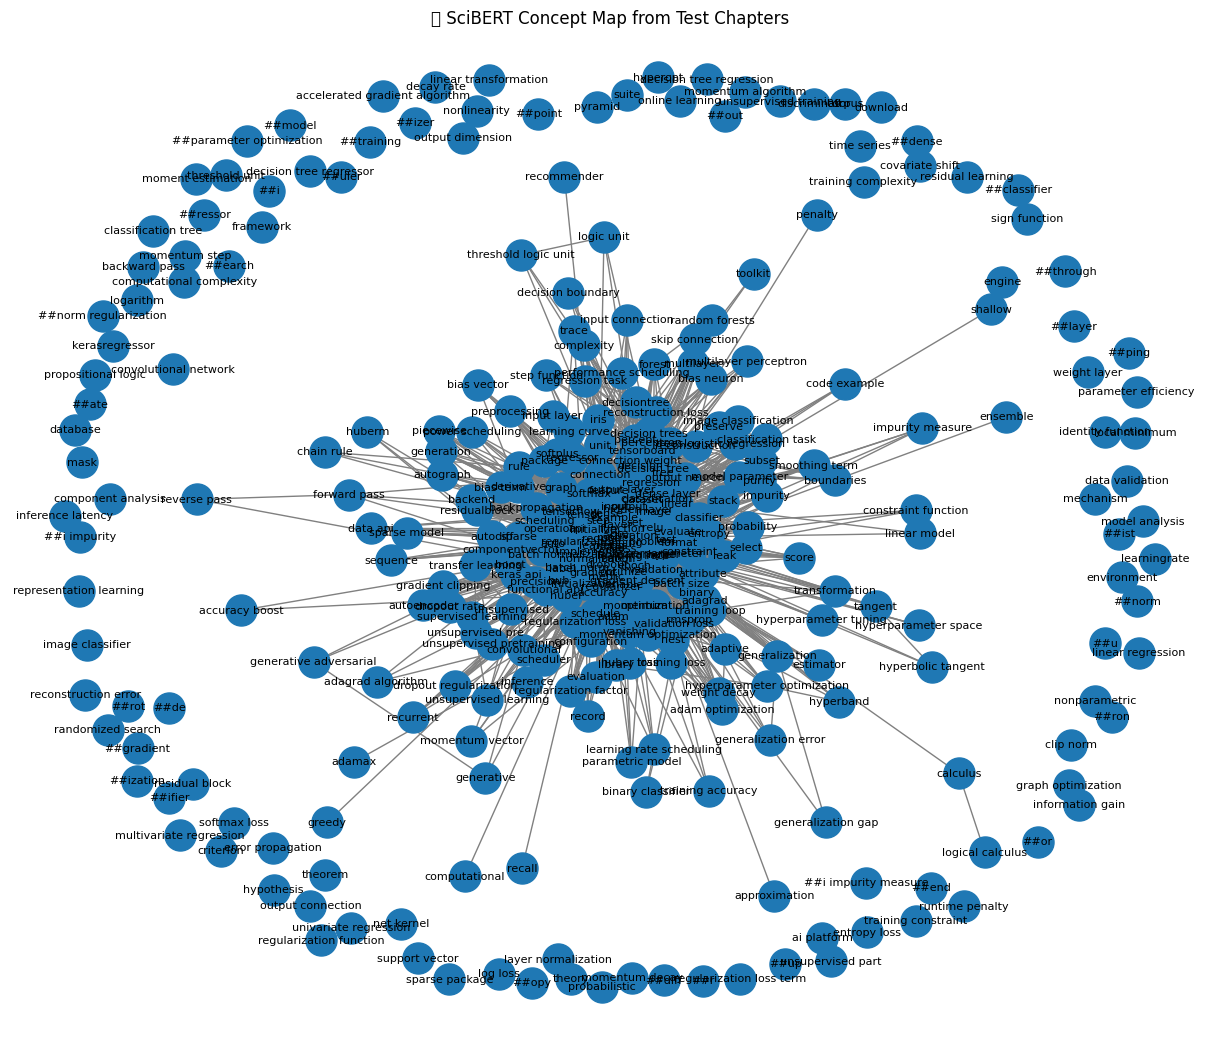

In [88]:
# --- PART 4: Build Concept Map from Test Predictions ---
import networkx as nx
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt

co_occurrence_edges = defaultdict(int)

for sent in test_sentences:
    sent = sent.lower()
    present = [p for p in extracted_test_phrases if p in sent]
    for c1, c2 in combinations(set(present), 2):
        co_occurrence_edges[tuple(sorted((c1, c2)))] += 1

# Build graph
G = nx.Graph()
for phrase in extracted_test_phrases:
    G.add_node(phrase)

for (c1, c2), w in co_occurrence_edges.items():
    if w >= 2:
        G.add_edge(c1, c2, weight=w)

# Visualize
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    font_size=8,
    edge_color="gray"
)
plt.title("🧠 SciBERT Concept Map from Test Chapters")
plt.show()
